<center>
    <p style="text-align:center">
        <img alt="BentoML logo" src="https://raw.githubusercontent.com/bentoml/BentoML/main/docs/source/_static/img/bentoml-logo-black.png" width="200"/>
        </br>
        <a href="https://github.com/bentoml/">GitHub</a>
        |
        <a href="https://l.bentoml.com/join-openllm-discord">Community</a>
    </p>
</center>
<h1 align="center">Serving blip image captioning with BentoML</h1>

BentoML is a framework for building reliable, scalable, and cost-efficient AI applications. It comes with everything you need for model serving, application packaging, and production deployment.

In this tutorial, you will learn the following:
- Set up your environment to work with BentoML
- Serve a REST API server for blip image captioning with just one-line command
- Explore different ways to interact with the server
- Build the bentos for deployment
- Production Deployment

## Set up

Before diving into this demo, let's ensure our environment has everything in place.

In [2]:
UPDATE_REPO = True  # @param {type:"boolean"}
PROJECT_NAME = "BentoML/examples/blip-image-captioning"

PROJECT_CURRENT = False

if not PROJECT_CURRENT:
    ![ ! -d $PROJECT_NAME ] && echo -= Initial setup =- && git clone https://github.com/bentoml/BentoML.git
    %cd $PROJECT_NAME
    PROJECT_CURRENT = True

if UPDATE_REPO:
    !echo -= Updating repo =- && git pull

print("Installing dependencies...")
!pip install -U -q -r requirements.txt
print("Done")

-= Initial setup =-
Cloning into 'BentoML'...
remote: Enumerating objects: 35924, done.
remote: Counting objects: 100% (3573/3573), done.
remote: Compressing objects: 100% (478/478), done.
remote: Total 35924 (delta 3235), reused 3147 (delta 3094), pack-reused 32351
Receiving objects: 100% (35924/35924), 67.03 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (25240/25240), done.
/content/BentoML/examples/blip-image-captioning
-= Updating repo =-
Already up to date.
Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

## Serve blip-image-captioning!

Fistly, let's download the model using bentoml sdk. This will save [blip-image-captioning-large](https://huggingface.co/Salesforce/blip-image-captioning-large) model in your local BentoML model store.

In [ ]:
import bentoml
from transformers import AutoProcessor, BlipForConditionalGeneration

model_id = "Salesforce/blip-image-captioning-large"

processor = AutoProcessor.from_pretrained(model_id)
model = BlipForConditionalGeneration.from_pretrained(model_id)

bentoml.transformers.save_model("blip-image-captioning-large", model)
bentoml.transformers.save_model("blip-image-captioning-large-processor", processor)

Model(tag="blip-image-captioning-large-processor:ertx2vdnsc4y4asc", path="/root/bentoml/models/blip-image-captioning-large-processor/ertx2vdnsc4y4asc/")

check and verify the models you just download

In [ ]:
!bentoml models list

 Tag                                          Module                Size        Creation Time       
 blip-image-captioning-large-processor:ertx…  bentoml.transformers  923.56 KiB  2023-10-18 08:27:14 
 blip-image-captioning-large:cvjy4atnsc4y4a…  bentoml.transformers  1.75 GiB    2023-10-18 08:26:49 


serving it is straightforward with BentoML. With just a single command, you're good to go:

> 👀 bentoml will start a server difinted in `service.py` listening 3000 port as deafult. And to unblock the following steps, we will run it in background via `nohup`

In [ ]:
! nohup bentoml serve service:svc > blip.log 2>&1 &

## Try blip image captioning server

### Check server status

Before you interact with the OpenLLM server, it's crucial to ensure that it is up and running. The output of the `curl` command should start with `HTTP/1.1 200 OK`, meaning everything is in order.

If it says `curl: (6) Could not resolve host: SERVER_URL`, ensure you have run the setup step.

If it says `curl: (7) Failed to connect to localhost...`, then check `./openllm.log` and `./openllm.err`; likely the server has failed to start or is still in the process of starting.

If it says `HTTP/1.1 503 Service Unavailable`, the server is still starting and you should wait a bit and retry.

In [ ]:
!curl -i http://127.0.0.1:3000/readyz

HTTP/1.1 200 OK
date: Wed, 18 Oct 2023 08:43:47 GMT
server: uvicorn
content-length: 1
content-type: text/plain; charset=utf-8




### Web UI
you can interact with the server via the Swagger UI at localhost:3000. Specifically, if runing in colab, you can visit the proxy URL below

In [ ]:
import sys

if "google.colab" in sys.modules:
    # using colab proxy URL
    from google.colab.output import eval_js

    print(
        "you are in colab runtime. please try it out in %s"
        % eval_js("google.colab.kernel.proxyPort(3000)")
    )

you are in colab runtime. please try it out in https://bdzjju4pv5w-496ff2e9c6d22116-3000-colab.googleusercontent.com/


### Raw HTTP

firstly, let's download a sample picture, and we will generate the captioning of this picture below

--2023-10-24 02:58:38--  https://raw.githubusercontent.com/bentoml/CLIP-API-service/main/images/three-dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50176 (49K) [image/jpeg]
Saving to: ‘three-dog.jpg’

three-dog.jpg       100%[===================>]  49.00K  --.-KB/s    in 0.01s   

2023-10-24 02:58:38 (4.04 MB/s) - ‘three-dog.jpg’ saved [50176/50176]



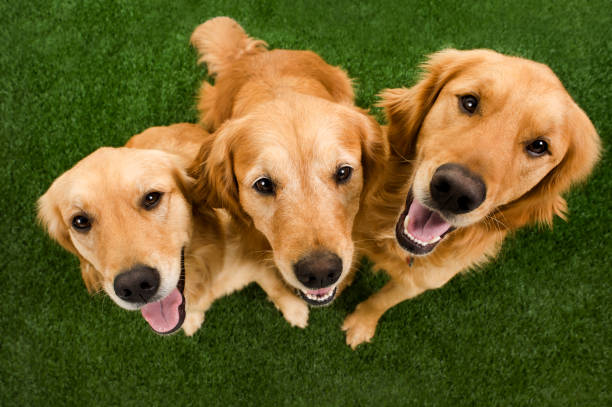

In [3]:
!wget https://raw.githubusercontent.com/bentoml/CLIP-API-service/main/images/three-dog.jpg -O three-dog.jpg
from IPython.display import Image, display

display(Image(filename="./three-dog.jpg"))

we can test the image captioning model under conditional or un-conditional by giving it a prompt input or not.

In [ ]:
!curl -X 'POST' \
  'http://127.0.0.1:3000/generate' \
  -H 'accept: text/plain' \
  -H 'Content-Type: multipart/form-data' \
  -F 'img=@three-dog.jpg;type=image/jpeg' \
  -F 'prompt='

three golden retrievers are sitting on the grass looking up

In [ ]:
!curl -X 'POST' \
  'http://127.0.0.1:3000/generate' \
  -H 'accept: text/plain' \
  -H 'Content-Type: multipart/form-data' \
  -F 'img=@three-dog.jpg;type=image/jpeg' \
  -F 'prompt=this picture is '

this picture is a picture of three dogs sitting on the grass

### BentoML client

⏰ NOTE: nest_asyncio allow nested use of `asyncio.run` and `loop.run_until_complete` to avoid such error as `RuntimeError: This event loop is already running` in notebook  

In [ ]:
from bentoml.client import Client
import PIL.Image

import nest_asyncio

nest_asyncio.apply()

client = Client.from_url("http://127.0.0.1:3000")
print(
    client.generate(
        img=PIL.Image.open("./three-dog.jpg"),
        prompt="this picture is",
    )
)

## Build Bento

Bento is the standardize distribution format, which is supported by an array of downstream deployment tools provided in the BentoML eco-system. It captures your service code, models, and configurations in one place, version control it automatically, and ensures reproducibility across yoru development and production environments. Learn more in [BentoML Documentation](https://docs.bentoml.com/en/latest/concepts/bento.html)

In [ ]:
!bentoml build -f bentofile.yaml


██████╗ ███████╗███╗   ██╗████████╗ ██████╗ ███╗   ███╗██╗
██╔══██╗██╔════╝████╗  ██║╚══██╔══╝██╔═══██╗████╗ ████║██║
██████╔╝█████╗  ██╔██╗ ██║   ██║   ██║   ██║██╔████╔██║██║
██╔══██╗██╔══╝  ██║╚██╗██║   ██║   ██║   ██║██║╚██╔╝██║██║
██████╔╝███████╗██║ ╚████║   ██║   ╚██████╔╝██║ ╚═╝ ██║███████╗
╚═════╝ ╚══════╝╚═╝  ╚═══╝   ╚═╝    ╚═════╝ ╚═╝     ╚═╝╚══════╝

Successfully built Bento(tag="image_captioning-svc:virrs2tnskexaasc").

Possible next steps:

 * Containerize your Bento with `bentoml containerize`:
    $ bentoml containerize image_captioning-svc:virrs2tnskexaasc  [or bentoml build --containerize]

 * Push to BentoCloud with `bentoml push`:
    $ bentoml push image_captioning-svc:virrs2tnskexaasc [or bentoml build --push]


## Production Deployment

BentoML provides a number of deployment options. The easiest way to set up a production-ready endpoint of your text embedding service is via BentoCloud, the serverless cloud platform built for BentoML, by the BentoML team.

Next steps:

1. Sign up for a BentoCloud account [here](https://www.bentoml.com/).
2. Get an API Token, see instructions [here](https://docs.bentoml.com/en/latest/bentocloud/getting-started/ship.html#acquiring-an-api-token).
3. Push your Bento to BentoCloud: `bentoml push sentence-embedding-svc:latest`
4. Deploy via Web UI, see [Deploying on BentoCloud](https://docs.bentoml.com/en/latest/bentocloud/getting-started/ship.html#deploying-your-bento)